In [35]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# Model
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large

# Model training
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer


# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [36]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

Total number of images  : 23708
Sample Image path       : 9_0_0_20170120133313910.jpg.chip.jpg
Sample Age              : 9
Sample Gender           : Male



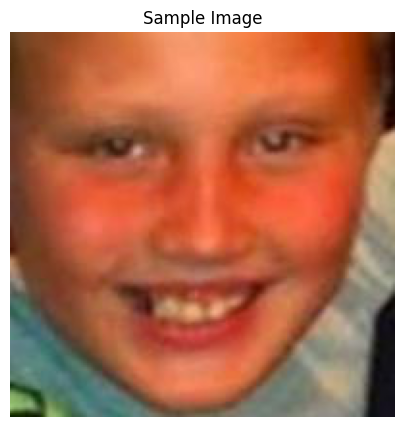

In [37]:
# Initialize the directory path
dir_path = "UTKFace/"
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [38]:
# Initialize a male counter variable
male_count = 0

# Initialize variable to store all the ages.
ages = []

# Loop over the paths and check for male images.
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Computee total female counts
female_count = len(image_paths) - male_count

# Visualizing The Class Imbalance
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.4,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()

bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)
bar_graph.show()


In [39]:
# Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()

# Violin Plot
fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()

# Box Plot
fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
)
fig.show()

In [40]:
# SHuffling the Images
np.random.shuffle(image_paths)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 21337
Testing Size  : 2371


In [41]:
def show_image(image, show=False):
    """
    Displays the provided image without axis.

    Args:
    - image (array-like): The image data to be displayed.
    - show (bool): If True, displays the image immediately. Defaults to False.

    Returns:
    - None
    """
    plt.imshow(image)
    plt.axis("off")

    if show:
        plt.show()


def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, gender

In [42]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

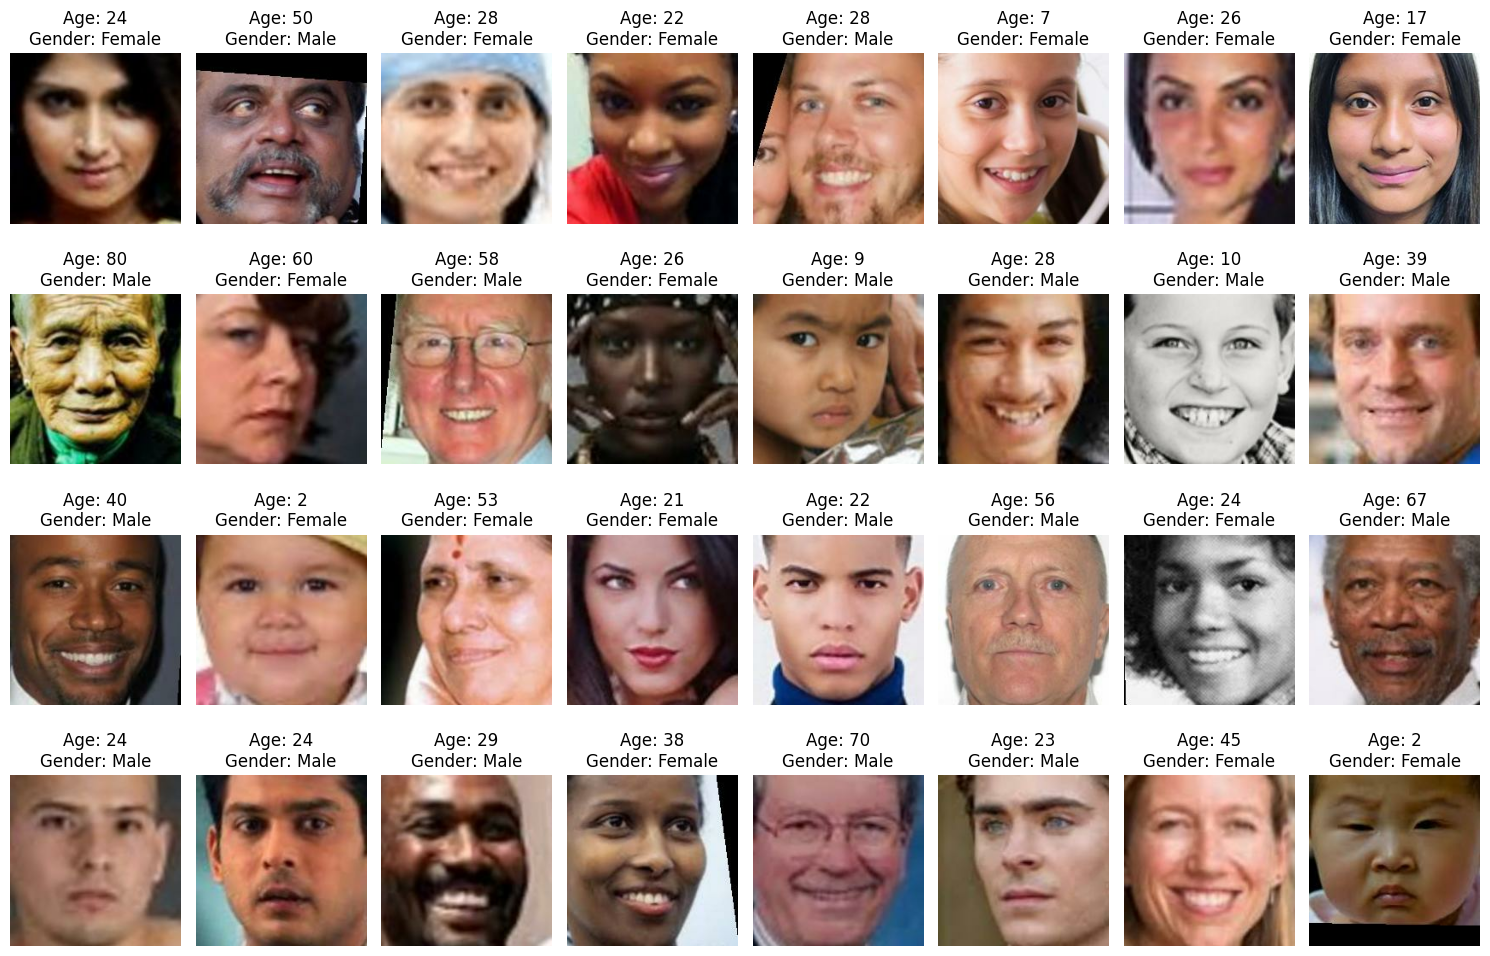

In [43]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [44]:
# Initializing all the Backbones
backbones = [
    (
        "VGG16",
        VGG16(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),
    (
        "ResNet50V2",
        ResNet50V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "ResNet152V2",
        ResNet152V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "Xception",
        Xception(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "InceptionV3",
        InceptionV3(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "MobileNetV3Small",
        MobileNetV3Small(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "MobileNetV3Large",
        MobileNetV3Large(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),
]

Testing : VGG16
Epoch 1/5
667/667 [==============================] - 6376s 10s/step - loss: 10.9379 - val_loss: 9.2821
Epoch 2/5
667/667 [==============================] - 6224s 9s/step - loss: 8.8969 - val_loss: 8.7899
Epoch 3/5
667/667 [==============================] - 8898s 13s/step - loss: 8.3961 - val_loss: 8.4314
Epoch 4/5
667/667 [==============================] - 9085s 14s/step - loss: 8.1358 - val_loss: 8.4055
Epoch 5/5
667/667 [==============================] - 9169s 14s/step - loss: 7.9354 - val_loss: 8.0831


Testing : ResNet50V2
Epoch 1/5
667/667 [==============================] - 2477s 4s/step - loss: 9.5561 - val_loss: 9.4595
Epoch 2/5
667/667 [==============================] - 2470s 4s/step - loss: 8.4869 - val_loss: 9.2594
Epoch 3/5
667/667 [==============================] - 1770s 3s/step - loss: 8.2082 - val_loss: 8.8021
Epoch 4/5
667/667 [==============================] - 1589s 2s/step - loss: 7.9050 - val_loss: 8.8153
Epoch 5/5
667/667 [============================

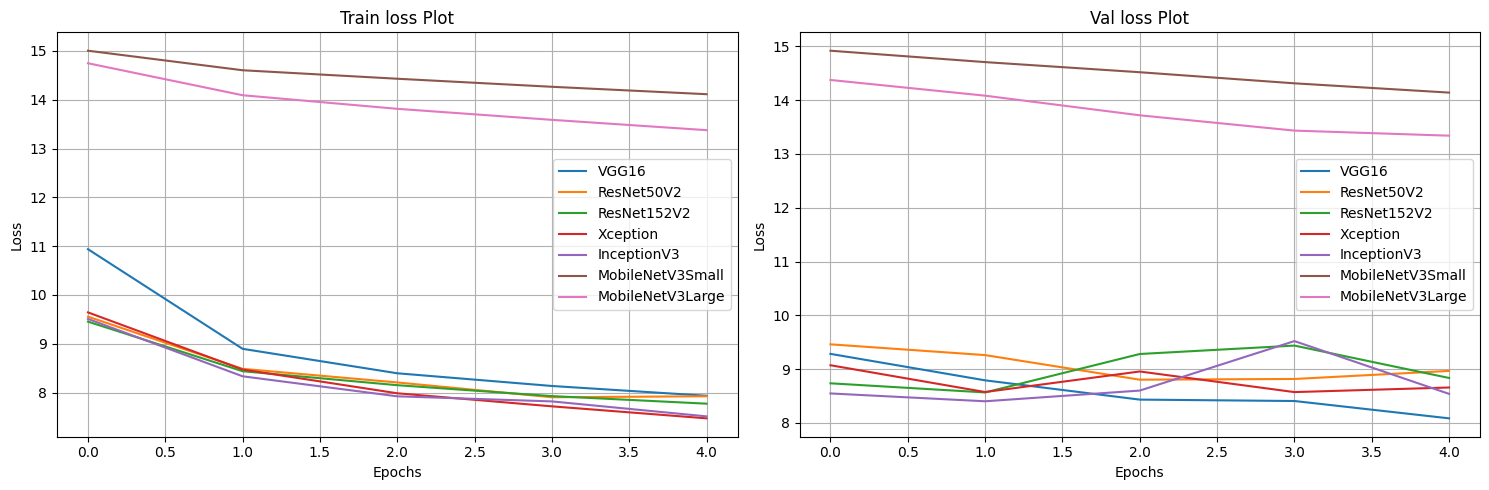

In [45]:
BACKBONE_HISTORIES = {}

for (name, backbone) in backbones:

    print(f"Testing : {name}")

    # Freeze the Model weights
    backbone.trainable = False

    # Creating a base model
    model = keras.Sequential([
        InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name = "InputLayer"),
        backbone,
        Dropout(0.2, name = "SlightDropout"),
        Flatten(name = "FlattenEmbeddings"),
        Dense(1, name = "Age")
    ])

    # Train the model for few iterations
    model.compile(
        loss = ["mae"],
        optimizer = "adam",
        weighted_metrics=[]
    )

    history = model.fit(
        train_age_ds,
        validation_data = valid_age_ds,
        epochs = 5,
        batch_size = BATCH_SIZE
    )

    BACKBONE_HISTORIES[name] = pd.DataFrame(history.history)
    #cls()
    #clear_output(wait=True)
    print("\n")
    metric = "loss"
plt.figure(figsize=(15, 5))
for i, sub in enumerate(['Train', 'Val']):

    plt.subplot(1, 2, i+1)
    plt.title(f"{sub} {metric} Plot")

    for name, history in BACKBONE_HISTORIES.items():
        plt.plot(history[metric] if sub=="Train" else history[f"val_{metric}"], label = name)
        plt.xlabel("Epochs")
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()
    

Testing : VGG16
Epoch 1/5

667/667 [==============================] - 7461s 11s/step - loss: 0.3600 - accuracy: 0.8406 - val_loss: 0.4296 - val_accuracy: 0.8140
Epoch 2/5
667/667 [==============================] - 8696s 13s/step - loss: 0.2824 - accuracy: 0.8808 - val_loss: 0.2857 - val_accuracy: 0.8773
Epoch 3/5
667/667 [==============================] - 10490s 16s/step - loss: 0.2526 - accuracy: 0.8964 - val_loss: 0.2686 - val_accuracy: 0.8870
Epoch 4/5
667/667 [==============================] - 9776s 15s/step - loss: 0.2323 - accuracy: 0.9024 - val_loss: 0.2769 - val_accuracy: 0.8815
Epoch 5/5
667/667 [==============================] - 11204s 17s/step - loss: 0.2182 - accuracy: 0.9113 - val_loss: 0.2995 - val_accuracy: 0.8790


Testing : ResNet50V2
Epoch 1/5
667/667 [==============================] - 2761s 4s/step - loss: 0.9517 - accuracy: 0.8325 - val_loss: 0.9298 - val_accuracy: 0.8714
Epoch 2/5
667/667 [==============================] - 2418s 4s/step - loss: 0.5640 - accuracy: 0

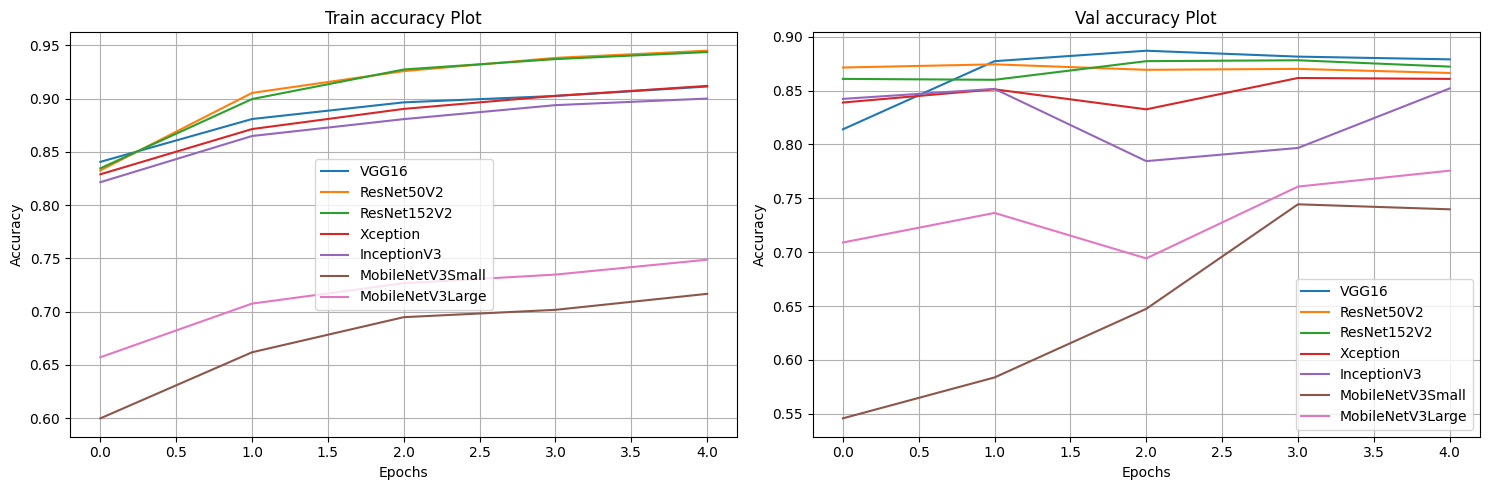

In [46]:
BACKBONE_HISTORIES = {}

for (name, backbone) in backbones:

    print(f"Testing : {name}")

    # Freeze the Model weights
    backbone.trainable = False

    # Creating a base model
    model = keras.Sequential([
        InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name = "InputLayer"),
        backbone,
        Dropout(0.2, name = "SlightDropout"),
        Flatten(name = "FlattenEmbeddings"),
        Dense(1, activation="sigmoid", name = "Age")
    ])

    # Train the model for few iterations
    model.compile(
        loss = ["binary_crossentropy"],
        optimizer = "adam",
        metrics = ['accuracy'],
        weighted_metrics=[]
    )

    history = model.fit(
        train_gender_ds,
        validation_data = valid_gender_ds,
        epochs = 5,
        batch_size = BATCH_SIZE
    )

    BACKBONE_HISTORIES[name] = pd.DataFrame(history.history)
    #cls()
    print("\n")
    metric = "accuracy"
plt.figure(figsize=(15, 5))
for i, sub in enumerate(['Train', 'Val']):

    plt.subplot(1, 2, i+1)
    plt.title(f"{sub} {metric} Plot")

    for name, history in BACKBONE_HISTORIES.items():
        plt.plot(history[metric] if sub=="Train" else history[f"val_{metric}"], label = name)
        plt.xlabel("Epochs")
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()
    

In [47]:
# Loading backbone
vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")

# Freezing the backbone weights
vgg_16.trainable = False

# Creating a Age Network
age_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    vgg_16,
    Dropout(0.4, name = "SlightDroput"),
    Flatten(name="FlattenEmbeddings"),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dense(1, name="AgeOutput")
], name="AgeNet")

# Compiling Model
age_net.compile(
    loss = "mae",
    optimizer = 'adam',
    weighted_metrics=[]
)

In [48]:
# Trining the Age Model
age_history = age_net.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_loss",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Age-VGG16.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
667/667 [==============================] - 8464s 13s/step - loss: 9.3210 - val_loss: 8.1954
Epoch 2/20
667/667 [==============================] - 8055s 12s/step - loss: 8.0203 - val_loss: 7.4230
Epoch 3/20
667/667 [==============================] - 7323s 11s/step - loss: 7.4755 - val_loss: 7.3011
Epoch 4/20
667/667 [==============================] - 8243s 12s/step - loss: 7.1329 - val_loss: 7.1010
Epoch 5/20
667/667 [==============================] - 5651s 8s/step - loss: 6.8925 - val_loss: 7.1201
Epoch 6/20
667/667 [==============================] - 5027s 8s/step - loss: 6.7663 - val_loss: 7.3948
Epoch 7/20
667/667 [==============================] - 4776s 7s/step - loss: 6.6965 - val_loss: 6.9509
Epoch 8/20
667/667 [==============================] - 5056s 8s/step - loss: 6.5431 - val_loss: 7.5217
Epoch 9/20
667/667 [==============================] - 5401s 8s/step - loss: 6.4365 - val_loss: 6.9019
Epoch 10/20
667/667 [==============================] - 8044s 12s/step - loss: 

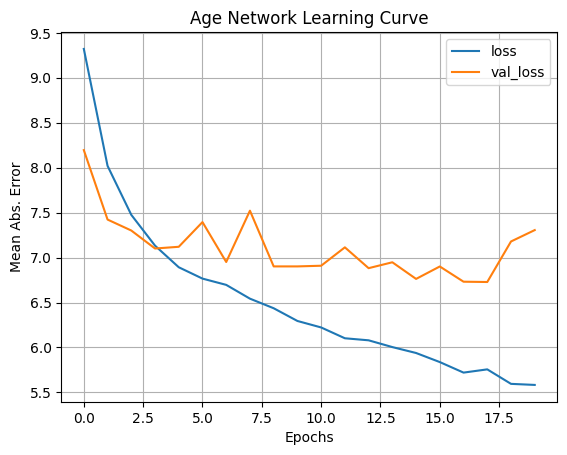

In [49]:
# Converting history into data frame.
age_his_df = pd.DataFrame(age_history.history)

# Visualization
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

In [50]:
# Initializing the backbone layer
resnet = ResNet152V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights="imagenet")

# Freeze the backbone weights
resnet.trainable = False

# Creating a gender model
gender_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    resnet,
    Dropout(0.2, name = "SlightDroput"),
    GlobalAveragePooling2D(name="GlobalAvgPooling"),
    Dense(1, activation="sigmoid", name="gender")
], name="GenderNet")

gender_net.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'],
    weighted_metrics=[]
)

In [51]:
# Training the Gender Model
gender_history = gender_net.fit(
    train_gender_ds,
    validation_data = valid_gender_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_accuracy",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Gender-ResNet152.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
667/667 [==============================] - 4724s 7s/step - loss: 0.3808 - accuracy: 0.8320 - val_loss: 0.3547 - val_accuracy: 0.8456
Epoch 2/20
667/667 [==============================] - 5671s 9s/step - loss: 0.3245 - accuracy: 0.8592 - val_loss: 0.3354 - val_accuracy: 0.8558
Epoch 3/20
667/667 [==============================] - 6670s 10s/step - loss: 0.3085 - accuracy: 0.8666 - val_loss: 0.3351 - val_accuracy: 0.8549
Epoch 4/20
667/667 [==============================] - 6548s 10s/step - loss: 0.3016 - accuracy: 0.8706 - val_loss: 0.3276 - val_accuracy: 0.8558
Epoch 5/20
667/667 [==============================] - 7708s 12s/step - loss: 0.2940 - accuracy: 0.8736 - val_loss: 0.3337 - val_accuracy: 0.8515
Epoch 6/20
667/667 [==============================] - 7214s 11s/step - loss: 0.2882 - accuracy: 0.8768 - val_loss: 0.3283 - val_accuracy: 0.8553
Epoch 7/20
667/667 [==============================] - 6242s 9s/step - loss: 0.2848 - accuracy: 0.8794 - val_loss: 0.3227 - val_accur

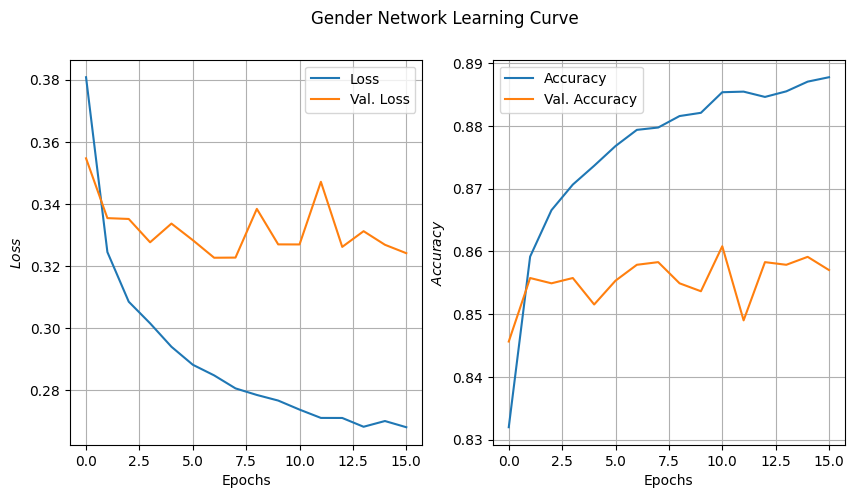

In [52]:
# Converting history into data frame.
gender_his_df = pd.DataFrame(gender_history.history)

# Visualization
plt.figure(figsize=(10, 5 ))
plt.subplot(1,2,1)
plt.suptitle("Gender Network Learning Curve")
plt.plot(gender_his_df['loss'], label="Loss")
plt.plot(gender_his_df['val_loss'], label="Val. Loss")
plt.xlabel("Epochs")
plt.ylabel("$Loss$")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(gender_his_df['accuracy'], label="Accuracy")
plt.plot(gender_his_df['val_accuracy'], label="Val. Accuracy")
plt.xlabel("Epochs")
plt.ylabel("$Accuracy$")
plt.grid()
plt.legend()

plt.show()

In [54]:
# Loading saved models
age_net = tf.keras.models.load_model("Age-VGG16.keras", compile=True)
gender_net = tf.keras.models.load_model("Gender-ResNet152.keras", compile=True)

In [55]:
# Evaluating test performance
age_net.evaluate(test_age_ds)
gender_net.evaluate(test_gender_ds)

75/75 [==============================] - 685s 9s/step - loss: 0.2679 - accuracy: 0.8849


[0.2678946554660797, 0.8848587274551392]

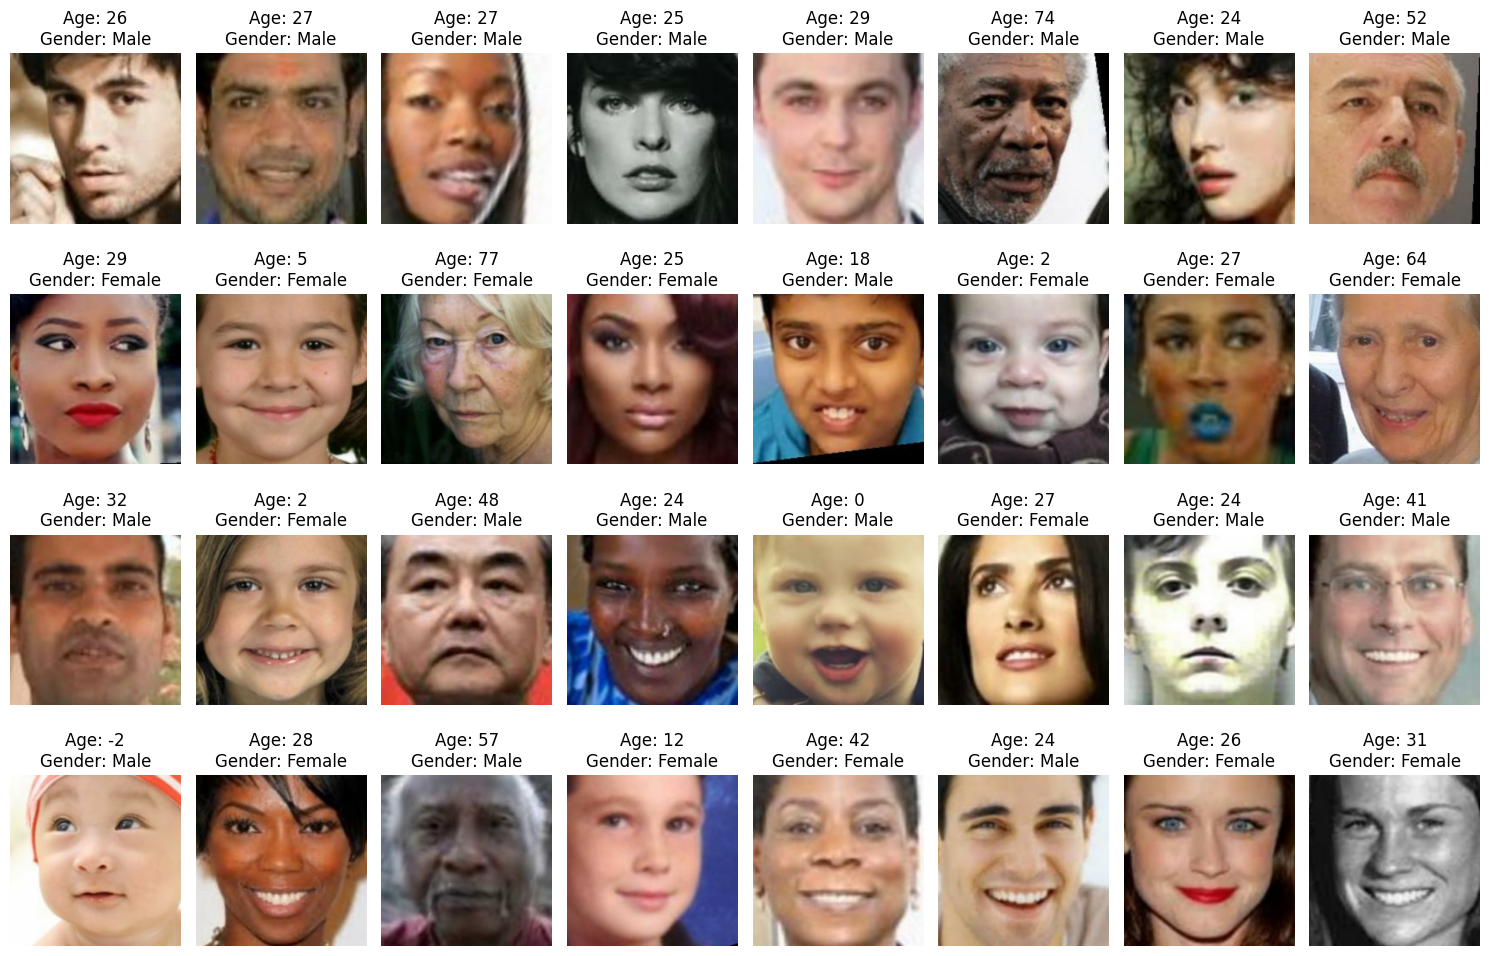

In [56]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):
    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])
        
        # Predictions
        pred_age = tf.round(tf.squeeze(age_net.predict(image, verbose=0)), 2)
        pred_gender = tf.round(tf.squeeze(gender_net.predict(image, verbose=0)))

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_age)}\nGender: {gender_mapping[int(pred_gender)]}")
        plt.axis("off")

plt.tight_layout()
plt.show()